In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb

In [2]:
import numpy as np
from scipy import sparse
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score

sys.path.append("..")
from inverse_hvp import inverse_hvp_lr_newtonCG
import argparse
import time
import pdb
import os
np.random.seed(0)

In [3]:
# select the dataset used
dataset_name = "mnist"
# regularization parameter for Logistic Regression
C = 0.1

In [20]:

# tool box
def load_mnist(validation_size = 5000):
    import gzip
    def _read32(bytestream):
        dt = np.dtype(np.uint32).newbyteorder(">")
        return np.frombuffer(bytestream.read(4),dtype=dt)[0]

    def extract_images(f):
        print("Extracting",f.name)
        with gzip.GzipFile(fileobj=f) as bytestream:
            magic = _read32(bytestream)
            num_images = _read32(bytestream)
            rows = _read32(bytestream)
            cols = _read32(bytestream)
            buf = bytestream.read(rows * cols * num_images)
            data = np.frombuffer(buf,dtype=np.uint8)
            data = data.reshape(num_images,rows,cols,1)
            return data
    
    def extract_labels(f):
        print('Extracting', f.name)
        with gzip.GzipFile(fileobj=f) as bytestream:
            magic = _read32(bytestream)
            num_items = _read32(bytestream)
            buf = bytestream.read(num_items)
            labels = np.frombuffer(buf, dtype=np.uint8)
            return labels

    #data_dir = "./data"
    data_dir = ""
    TRAIN_IMAGES = os.path.join(data_dir,'train-images-idx3-ubyte.gz')
    with open(TRAIN_IMAGES,"rb") as f:
        train_images = extract_images(f)

    TRAIN_LABELS =  os.path.join(data_dir,'train-labels-idx1-ubyte.gz')
    with open(TRAIN_LABELS,"rb") as f:
        train_labels = extract_labels(f)

    TEST_IMAGES =  os.path.join(data_dir,'t10k-images-idx3-ubyte.gz')
    with open(TEST_IMAGES,"rb") as f:
        test_images = extract_images(f)

    TEST_LABELS =  os.path.join(data_dir,'t10k-labels-idx1-ubyte.gz')
    with open(TEST_LABELS,"rb") as f:
        test_labels = extract_labels(f)

    # split train and val
    # train_images = train_images[validation_size:]
    # train_labels = train_labels[validation_size:]

    # preprocessing
    # train_images = train_images.astype(np.float32) / 255
    # test_images  = test_images.astype(np.float32) / 255
    
    # reshape for logistic regression
    # train_images = np.reshape(train_images, [train_images.shape[0], -1])
    # test_images = np.reshape(test_images, [test_images.shape[0], -1])
    return train_images,train_labels,test_images,test_labels

def load_data_two_class(dataset_name,va_ratio):
  x_train,y_train,x_test,y_test = load_mnist()
  pos_class = 1
  neg_class = 7
  x_train,y_train = filter_dataset(x_train,y_train,pos_class,neg_class)
  x_va,y_va = filter_dataset(x_test,y_test,pos_class,neg_class)
  y_va = y_va.astype(int)
  y_train = y_train.astype(int)

  num_va_sample = int((1-va_ratio) * x_train.shape[0])
  x_val = x_train[num_va_sample:]
  y_val = y_train[num_va_sample:]
  x_train = x_train[:num_va_sample]
  y_train = y_train[:num_va_sample]
  x_te = x_va
  y_te = y_va

  return x_train,y_train,x_val,y_val,x_te,y_te


def filter_dataset(X, Y, pos_class, neg_class, mode=None):
    
    """
    Filters out elements of X and Y that aren't one of pos_class or neg_class
    then transforms labels of Y so that +1 = pos_class, -1 = neg_class.

    They are all 10-classes image classification data sets while Logistic regression can only handle binary classification. we
    select the number 1 and 7 as positive and negative classes;
    """

    assert(X.shape[0] == Y.shape[0])
    assert(len(Y.shape) == 1)

    Y = Y.astype(int)
    
    pos_idx = Y == pos_class
    neg_idx = Y == neg_class        
    Y[pos_idx] = 1
    Y[neg_idx] = -1
    idx_to_keep = pos_idx | neg_idx
    X = X[idx_to_keep, ...]
    Y = Y[idx_to_keep]
    if Y.min() == -1 and mode != "svm":
        Y = (Y + 1) / 2
        Y.astype(int)
    return (X, Y)

# load data, pick 30% as the Va set
x_train,y_train,x_va,y_va,x_te,y_te = load_data_two_class(dataset_name,va_ratio=0.3)



print("x_train, nr sample {}, nr feature {}".format(x_train.shape[0],x_train.shape[1]))
print("x_va,    nr sample {}, nr feature {}".format(x_va.shape[0],x_va.shape[1]))
print("x_te,    nr sample {}, nr feature {}".format(x_te.shape[0],x_te.shape[1]))
print("Tr: Pos {} Neg {}".format(y_train[y_train==1].shape[0],y_train[y_train==0].shape[0]))
print("Va: Pos {} Neg {}".format(y_va[y_va==1].shape[0],y_va[y_va==0].shape[0]))
print("Te: Pos {} Neg {}".format(y_te[y_te==1].shape[0],y_te[y_te==0].shape[0]))

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz
x_train, nr sample 9104, nr feature 28
x_va,    nr sample 3903, nr feature 28
x_te,    nr sample 2163, nr feature 28
Tr: Pos 4784 Neg 4320
Va: Pos 1958 Neg 1945
Te: Pos 1135 Neg 1028


In [22]:
x_train[0].shape

(28, 28, 1)

In [23]:
num_tr_sample = x_train.shape[0]
sample_ratio = 0.6
obj_sample_size = int(sample_ratio * num_tr_sample)


"""
# Our unweighted method can downweight the bad cases which cause high test loss to the our model, which is an important reason of its ability to improve result with less data.
To show the performance of our methods in noisy label situation, we perform addtional experiments with some training
labels being flipped. The results show the enlarging superiority of our subsampling methods 
"""

# flip labels
idxs = np.arange(y_train.shape[0])
flip_ratio = 0.4
np.random.shuffle(idxs)
num_flip = int(flip_ratio * len(idxs))
y_train[idxs[:num_flip]] = np.logical_xor(np.ones(num_flip), y_train[idxs[:num_flip]]).astype(int)

In [6]:

# define the full-set-model 

""" 
model : logistic regression:
C: Inverse of regularization strength. smaller values specify stronger regularization.
fit_intercept: constant (a.k.a. bias or intercept) should be added to the decision function.
tol: Tolerance for stopping criteria.
solver: Algorithm to use in the optimization problem.For small datasets, ‘liblinear’ is a good choice
multi_class: ‘ovr’, then a binary problem is fit for each label.
max_iterint: Maximum number of iterations taken for the solvers to converge
"""

clf = LogisticRegression(
        C = C,
        fit_intercept=False,
        tol = 1e-8,
        solver="liblinear",
        multi_class="ovr",
        max_iter=100,
        warm_start=False,
        verbose=1,
        )

clf.fit(x_train,y_train)

# on Va

y_va_pred = clf.predict_proba(x_va)[:,1] 
#predict_proba : Probability estimates. The returned estimates for all classes are ordered by the label of classes.
full_logloss = log_loss(y_va,y_va_pred) 
#Log loss, aka logistic loss or cross-entropy loss. This is the loss function defined as the negative log-likelihood of a logistic model that returns y_pred probabilities for its training data y_true. 
#For a single sample with true label yt in {0,1} and estimated probability yp that yt = 1, the log loss is
#-log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))
weight_ar = clf.coef_.flatten() 
#Coefficient of the features in the decision function. coef_ is of shape (1, n_features) when the given problem is binary.

# on Te

y_te_pred = clf.predict_proba(x_te)[:,1]
full_te_logloss = log_loss(y_te,y_te_pred)
full_te_auc = roc_auc_score(y_te, y_te_pred)
#The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.
# The true-positive rate is also known as sensitivity, recall or probability of detection
# The false-positive rate is also known as probability of false alarm 
# AUC measures how true positive rate (recall) and false positive rate trade off

y_te_pred = clf.predict(x_te)
full_te_acc = (y_te == y_te_pred).sum() / y_te.shape[0]


# print full-set-model results
print("[FullSet] Va logloss {:.6f}".format(full_logloss))
print("[FullSet] Te logloss {:.6f}".format(full_te_logloss))

[LibLinear]iter  1 act 1.784e+01 pre 1.766e+01 delta 2.238e-01 f 5.770e+02 |g| 2.249e+02 CG   4
cg reaches trust region boundary
iter  2 act 1.948e+00 pre 1.946e+00 delta 2.357e-01 f 5.592e+02 |g| 2.199e+01 CG   4
cg reaches trust region boundary
iter  3 act 2.042e+00 pre 2.040e+00 delta 3.111e-01 f 5.573e+02 |g| 2.639e+01 CG   5
cg reaches trust region boundary
iter  4 act 1.871e+00 pre 1.869e+00 delta 4.825e-01 f 5.552e+02 |g| 1.447e+01 CG   5
cg reaches trust region boundary
iter  5 act 1.743e+00 pre 1.738e+00 delta 5.484e-01 f 5.533e+02 |g| 1.329e+01 CG   6
cg reaches trust region boundary
iter  6 act 1.800e+00 pre 1.791e+00 delta 6.828e-01 f 5.516e+02 |g| 1.205e+01 CG   7
cg reaches trust region boundary
iter  7 act 1.148e+00 pre 1.147e+00 delta 7.735e-01 f 5.498e+02 |g| 1.293e+01 CG   8
iter  8 act 5.453e-01 pre 5.448e-01 delta 7.735e-01 f 5.487e+02 |g| 5.447e+00 CG  16
iter  9 act 1.441e-02 pre 1.441e-02 delta 7.735e-01 f 5.481e+02 |g| 5.371e-01 CG  25
iter 10 act 1.435e-04 pre 

In [7]:
def grad_logloss_theta_lr(label,ypred,x,C=0.03,has_l2=True,scale_factor=1.0):
    """Return d l_i / d_theta = d l_i / d_ypred * d y_pred / d theta
        grad_logloss_theta: gradient on the theta, shape: [n,]
    """
    # The isinstance() function returns True if the specified object is of the specified type, otherwise False.
    if not isinstance(label,np.ndarray) or not isinstance(ypred,np.ndarray):
        label = np.array(label).flatten()
        ypred = np.array(ypred).flatten()


    grad_logloss_theta = C * x.T.dot(ypred-label)

    return scale_factor * grad_logloss_theta

def batch_grad_logloss_lr(label,ypred,x,C=0.03,scale_factor=1.0):
    """Return gradient on a batch.
        batch_grad: gradient of each sample on parameters,
            has shape [None,n]
    """
    diffs = ypred - label
    if isinstance(x,np.ndarray):
        diffs = diffs.reshape(-1,1)
        batch_grad = x * diffs
    else:
        diffs = sparse.diags(diffs)
        batch_grad = x.T.dot(diffs).T
    batch_grad = sparse.csr_matrix(C * batch_grad)      
    return scale_factor * batch_grad

In [8]:
# building precoditioner
test_grad_loss_val = grad_logloss_theta_lr(y_va,y_va_pred,x_va,C,0.1/(num_tr_sample*C))  #Return d l_i / d_theta

tr_pred = clf.predict_proba(x_train)[:,1]
batch_size = 10000
M = None
total_batch = int(np.ceil(num_tr_sample / float(batch_size)))

for idx in range(total_batch):
    batch_tr_grad = batch_grad_logloss_lr(y_train[idx*batch_size:(idx+1)*batch_size],
        tr_pred[idx*batch_size:(idx+1)*batch_size],
        x_train[idx*batch_size:(idx+1)*batch_size],
        C,
        1.0)

    sum_grad = batch_tr_grad.multiply(x_train[idx*batch_size:(idx+1)*batch_size]).sum(0)
    if M is None:
        M = sum_grad
    else:
        M = M + sum_grad       
M = M + 0.1/(num_tr_sample*C) * np.ones(x_train.shape[1])
M = np.array(M).flatten()

# computing the inverse Hessian-vector-product
#The Hessian Matrix is a square matrix of second ordered partial derivatives of a scalar function.
#It is of immense use in linear algebra as well as for determining points of local maxima or minima
iv_hvp = inverse_hvp_lr_newtonCG(x_train,y_train,tr_pred,test_grad_loss_val,C,True,1e-5,True,M,0.1/(num_tr_sample*C))

# get influence score
total_batch = int(np.ceil(x_train.shape[0] / float(batch_size)))
predicted_loss_diff = []
for idx in range(total_batch):
    train_grad_loss_val = batch_grad_logloss_lr(y_train[idx*batch_size:(idx+1)*batch_size],
        tr_pred[idx*batch_size:(idx+1)*batch_size],
        x_train[idx*batch_size:(idx+1)*batch_size],
        C,
        1.0)
    predicted_loss_diff.extend(np.array(train_grad_loss_val.dot(iv_hvp)).flatten())    
predicted_loss_diffs = np.asarray(predicted_loss_diff)

print("=="*30)
print("IF(influence function) Stats: mean {:.10f}, max {:.10f}, min {:.10f}".format(
    predicted_loss_diffs.mean(), predicted_loss_diffs.max(), predicted_loss_diffs.min())
)

/home/pnans/Documents/GitHub/Unweighted-Data-Subsampling-via-Influence-Function/inverse_hvp.py:146: OptimizeWarning: Unknown solver options: preconditioner
  fmin_results = fmin_ncg(f=fmin_loss_fn,


Succeed in getting the inverse of preconditioner M.
iter 0 cg iter 0 iter_diff 4305.735512646801
Function value: -360480.4532690004
Split function value: 363857.5355531955, -724337.9888221959
iter 1 cg iter 0 iter_diff 994.9107666369654
Function value: -402211.57174907194
Split function value: 372196.4301940192, -774408.0019430912
iter 2 cg iter 0 iter_diff 480.3468302419942
Function value: -437606.79833226895
Split function value: 439776.61213072226, -877383.4104629912
iter 3 cg iter 0 iter_diff 203.96676376517718
iter 3 cg iter 10 iter_diff 103.06986903307417
Function value: -469177.5246129272
Split function value: 476194.82317021757, -945372.3477831448
iter 4 cg iter 0 iter_diff 79.42536795709998
iter 4 cg iter 10 iter_diff 46.498857427336254
Function value: -475866.23644338455
Split function value: 465757.77973365155, -941624.0161770361
iter 5 cg iter 0 iter_diff 33.34395773833848
iter 5 cg iter 10 iter_diff 16.0987010186897
Function value: -476560.76464876404
Split function value:

In [9]:
def select_from_one_class(y_train,prob_pi,label,ratio):
    # select positive and negative samples respectively
    num_sample = y_train[y_train==label].shape[0]
    all_idx = np.arange(y_train.shape[0])[y_train==label]
    label_prob_pi = prob_pi[all_idx]
    obj_sample_size = int(ratio * num_sample)

    sb_idx = None
    iteration = 0
    while True:
        rand_prob = np.random.rand(num_sample)
        iter_idx = all_idx[rand_prob < label_prob_pi]
        if sb_idx is None:
            sb_idx = iter_idx
        else:
            new_idx = np.setdiff1d(iter_idx, sb_idx)
            diff_size = obj_sample_size - sb_idx.shape[0]
            if new_idx.shape[0] < diff_size:
                sb_idx = np.union1d(iter_idx, sb_idx)
            else:
                new_idx = np.random.choice(new_idx, diff_size, replace=False)
                sb_idx = np.union1d(sb_idx, new_idx)
        iteration += 1
        if sb_idx.shape[0] >= obj_sample_size:
            sb_idx = np.random.choice(sb_idx,obj_sample_size,replace=False)
            return sb_idx

        if iteration > 100:
            diff_size = obj_sample_size - sb_idx.shape[0]
            leave_idx = np.setdiff1d(all_idx, sb_idx)
            # left samples are sorted by their IF
            # leave_idx = leave_idx[np.argsort(prob_pi[leave_idx])[-diff_size:]]
            leave_idx = np.random.choice(leave_idx,diff_size,replace=False)
            sb_idx = np.union1d(sb_idx, leave_idx)
            return sb_idx

In [10]:
# build sampling probability

sigmoid_k = 10  # parameter for the sigmoid sampling function
phi_ar = - predicted_loss_diffs
IF_interval = phi_ar.max() - phi_ar.min()
a_param = sigmoid_k / IF_interval
prob_pi = 1 / (1 + np.exp(a_param * phi_ar))
print("Pi Stats:",np.percentile(prob_pi,[10,25,50,75,90]))

Pi Stats: [0.08010065 0.1627333  0.66298381 0.79176391 0.8593959 ]


In [11]:
pos_idx = select_from_one_class(y_train,prob_pi,1,sample_ratio)
neg_idx = select_from_one_class(y_train,prob_pi,0,sample_ratio)
sb_idx = np.union1d(pos_idx,neg_idx)
sb_x_train = x_train[sb_idx]
sb_y_train = y_train[sb_idx]

In [12]:
clf.fit(sb_x_train,sb_y_train)
y_va_pred = clf.predict_proba(x_va)[:,1]
sb_logloss = log_loss(y_va, y_va_pred)
sb_weight = clf.coef_.flatten()
diff_w_norm = np.linalg.norm(weight_ar - sb_weight)
sb_size = sb_x_train.shape[0]
y_te_pred = clf.predict_proba(x_te)[:,1]
sb_te_logloss = log_loss(y_te,y_te_pred)
sb_te_auc = roc_auc_score(y_te, y_te_pred)
y_te_pred = clf.predict(x_te)
sb_te_acc = (y_te == y_te_pred).sum() / y_te.shape[0]

[LibLinear]iter  1 act 1.246e+02 pre 1.145e+02 delta 5.750e-01 f 3.462e+02 |g| 4.817e+02 CG   3
cg reaches trust region boundary
iter  2 act 1.454e+01 pre 1.312e+01 delta 6.991e-01 f 2.216e+02 |g| 8.830e+01 CG   4
cg reaches trust region boundary
iter  3 act 4.924e+00 pre 4.722e+00 delta 8.327e-01 f 2.070e+02 |g| 2.178e+01 CG   4
cg reaches trust region boundary
iter  4 act 3.154e+00 pre 3.148e+00 delta 9.560e-01 f 2.021e+02 |g| 1.198e+01 CG   5
cg reaches trust region boundary
iter  5 act 2.026e+00 pre 1.978e+00 delta 1.016e+00 f 1.990e+02 |g| 7.115e+00 CG   7
iter  6 act 8.089e-01 pre 8.088e-01 delta 1.016e+00 f 1.969e+02 |g| 4.989e+00 CG  13
iter  7 act 1.580e-02 pre 1.578e-02 delta 1.016e+00 f 1.961e+02 |g| 8.397e-01 CG  14
iter  8 act 3.571e-04 pre 3.571e-04 delta 1.016e+00 f 1.961e+02 |g| 6.139e-02 CG  18
iter  9 act 1.186e-06 pre 1.186e-06 delta 1.016e+00 f 1.961e+02 |g| 5.604e-03 CG  14
iter 10 act 2.320e-08 pre 2.320e-08 delta 1.016e+00 f 1.961e+02 |g| 5.316e-04 CG  16
iter 11

In [13]:
# baseline model: random sampling

u_idxs = np.arange(x_train.shape[0])
uniform_idxs = np.random.choice(u_idxs,obj_sample_size,replace=False)
us_x_train = x_train[uniform_idxs]
us_y_train = y_train[uniform_idxs]
clf.fit(us_x_train, us_y_train)
y_va_pred = clf.predict_proba(x_va)[:,1]
us_logloss = log_loss(y_va, y_va_pred)
us_size = us_x_train.shape[0]
y_te_pred = clf.predict_proba(x_te)[:,1]
us_te_logloss = log_loss(y_te,y_te_pred)
us_te_auc = roc_auc_score(y_te, y_te_pred)
y_te_pred = clf.predict(x_te)
us_te_acc = (y_te == y_te_pred).sum() / y_te.shape[0]

[LibLinear]iter  1 act 1.276e+01 pre 1.258e+01 delta 4.898e-01 f 3.462e+02 |g| 1.361e+02 CG   5
cg reaches trust region boundary
iter  2 act 2.358e+00 pre 2.373e+00 delta 5.391e-01 f 3.335e+02 |g| 1.261e+01 CG   5
cg reaches trust region boundary
iter  3 act 2.198e+00 pre 2.183e+00 delta 6.885e-01 f 3.311e+02 |g| 1.069e+01 CG   6
cg reaches trust region boundary
iter  4 act 1.393e+00 pre 1.391e+00 delta 7.241e-01 f 3.289e+02 |g| 6.927e+00 CG   7
cg reaches trust region boundary
iter  5 act 1.037e+00 pre 1.031e+00 delta 7.585e-01 f 3.275e+02 |g| 7.856e+00 CG   9
iter  6 act 2.424e-01 pre 2.424e-01 delta 7.585e-01 f 3.265e+02 |g| 4.735e+00 CG  14
iter  7 act 7.395e-03 pre 7.395e-03 delta 7.585e-01 f 3.262e+02 |g| 3.683e-01 CG  20
iter  8 act 5.608e-05 pre 5.608e-05 delta 7.585e-01 f 3.262e+02 |g| 3.337e-02 CG  22
iter  9 act 3.056e-07 pre 3.056e-07 delta 7.585e-01 f 3.262e+02 |g| 2.430e-03 CG  19
iter 10 act 4.799e-09 pre 4.799e-09 delta 7.585e-01 f 3.262e+02 |g| 2.403e-04 CG  21
iter 11

In [14]:
print("=="*30)
print("Result Summary on Va")
print("[UIDS]  logloss {:.6f}, # {}".format(sb_logloss,sb_size))
print("[Random]   logloss {:.6f}, # {}".format(us_logloss,us_size))
print("[Full]     logloss {:.6f}, # {}".format(full_logloss,num_tr_sample))

print("Result Summary on Te")
print("[UIDS]  logloss {:.6f}, # {}".format(sb_te_logloss,sb_size))
print("[Random]   logloss {:.6f}, # {}".format(us_te_logloss,us_size))
print("[Full]     logloss {:.6f}, # {}".format(full_te_logloss,num_tr_sample))
print("=="*30)
# Attention: if the dataset used here is small, one experiment may fail because of uncertainty of subsampling!

Result Summary on Va
[UIDS]  logloss 0.162497, # 4994
[Random]   logloss 0.527064, # 4995
[Full]     logloss 0.525831, # 8325
Result Summary on Te
[UIDS]  logloss 0.176543, # 4994
[Random]   logloss 0.524031, # 4995
[Full]     logloss 0.522210, # 8325


In [15]:
print("=="*30)
print("Result Summary on Te (ACC and AUC)")
print("[UIDS]  acc {:.6f}, auc {:.6f} # {}".format(sb_te_acc,sb_te_auc, sb_size))
print("[Random]   acc {:.6f}, auc {:.6f} # {}".format(us_te_acc,us_te_auc, us_size))
print("[Full]     acc {:.6f}, auc {:.6f} # {}".format(full_te_acc,full_te_auc, num_tr_sample))
print("=="*30)

Result Summary on Te (ACC and AUC)
[UIDS]  acc 0.984281, auc 0.998802 # 4994
[Random]   acc 0.900139, auc 0.950359 # 4995
[Full]     acc 0.916782, auc 0.961824 # 8325


In [16]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

TypeError: Invalid shape (784,) for image data

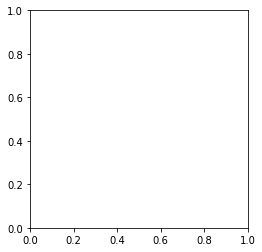

In [19]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(x_te[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_te[0]))

In [17]:
%%time
explanation = explainer.explain_instance(x_te[0], 
                                         classifier_fn = clf.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=1000, segmentation_fn=segmenter)

ValueError: Input array must have a shape == (..., 3)), got (1, 784, 1)